In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ginga.util import iqcalc

In [2]:
# import LAM library for logbook, data analysis...
from pfs.sacFileHandling import stackedImage, Logbook, constructFilelist, getDateObs
from pfs.imageAnalysis import fitparabola, getEE

In [3]:
imgPath = '/home/pfs/shared/Pictures/SM1/SLITALIGN'

In [4]:
smId = 1

In [5]:
# filepath of data model
pmodel = '/home/pfs/dev/ait-notebook/optical/input/slit'
file = 'slit-defParam-Ouverture100-fiber65.csv'

In [6]:
zemaxData = pd.read_csv('%s/%s' % (pmodel, file), delimiter=" ")
zemaxMidFit = fitparabola(x=zemaxData.Slitdefocus, y=zemaxData.MidFiber, deg=15, focus='max')
zemaxEndFit = fitparabola(x=zemaxData.Slitdefocus, y=zemaxData.ExtremeFiber, deg=15, focus='max')

In [7]:
def getFiberPeak(filelist, ind, duplicate, doMeanBck, crit, radius=60, threshold=1000):
    calc = iqcalc.IQCalc(None)
    hdr, data = stackedImage(filelist=filelist, ind=ind, duplicate=duplicate, doMeanBck=doMeanBck)
    fca_x = hdr['FCA_X']

    peaks = calc.find_bright_peaks(data, threshold=threshold, radius=radius)

    objlist = calc.evaluate_peaks(peaks, data, fwhm_radius=radius, cb_fn=None, ev_intr=None, fwhm_method='gaussian')
    objlist = [elem for elem in objlist if elem['fwhm'] > 15]
    objlist = [elem for elem in objlist if 1000 < elem['brightness'] < 50000]
    if not objlist:
        raise ValueError('peak has not been properly detected')

    for peak in objlist:
        peak['fca_x'] = fca_x
        peak['EE'] = getEE(image=data, cx=peak['objx'], cy=peak['objy'], inner_size=20, outer_size=150)
        peak['flux_EE'] = np.sum(data)
        # center of mass
        peak['com_EE'] = getEE(image=data, cx=peak['oid_x'], cy=peak['oid_y'], inner_size=20, outer_size=150)

    maxi = np.argmax([obj[crit] for obj in objlist])
    
    return objlist[maxi]


def getDescription(experimentId):
    visitStart, visitEnd = Logbook.visitRange(experimentId=experimentId)
    filelist = constructFilelist(visitStart=visitStart, visitEnd=visitEnd)
    fibername = Logbook.getParameter(experimentId=experimentId, param='fiber')
    duplicate = int(Logbook.getParameter(experimentId=experimentId, param='duplicate'))
    dateobs = getDateObs(experimentId=experimentId)

    description = pd.DataFrame([(experimentId, dateobs, len(filelist), visitStart, visitEnd, fibername, duplicate)],
                               columns=['experimentId', 'dateobs', 'nbImages', 'visitStart', 'visitEnd', 'fiber',
                                        'duplicate'])

    return description


def getFiberTF(experimentId, doMeanBck, centerOfMass):
    visitStart, visitEnd = Logbook.visitRange(experimentId=experimentId)
    filelist = constructFilelist(visitStart=visitStart, visitEnd=visitEnd)
    duplicate = int(Logbook.getParameter(experimentId=experimentId, param='duplicate'))

    crit = 'com_EE' if centerOfMass else 'EE'
    res = []

    for i in range(len(filelist) // duplicate):
        try:
            fiberPeak = getFiberPeak(filelist, ind=i, duplicate=duplicate,
                                     doMeanBck=doMeanBck,
                                     crit=crit)
            res.append((experimentId,) + tuple(list(fiberPeak.values())))

        except ValueError:
            pass

    return pd.DataFrame(res, columns=['experimentId'] + list(fiberPeak.keys()))

In [8]:
experiments = pd.read_sql_query('select * from Experiment where experimentId>89 order by experimentId desc',
                                con='sqlite:////data/ait/ait-alignment.db', index_col='experimentId')

experiments['exptime'] = [Logbook.getParameter(experimentId, 'exptime') for experimentId in experiments.index]
experiments['fiber'] = [Logbook.getParameter(experimentId, 'fiber') for experimentId in experiments.index]
experiments['dateobs'] = [getDateObs(experimentId=experimentId) for experimentId in experiments.index]

experiments

,name,visitStart,visitEnd,type,cmdStr,comments,anomalies,exptime,fiber,dateobs
experimentId,,,,,,,,,,
118,,5131,5150,Slit_Alignment,slit throughfocus exptime=6.0 lowBound=-1.5 up...,small angle adjust verif,,6.0,engbotmid,2018-08-02T08:40:08
117,,5111,5130,Slit_Alignment,slit throughfocus exptime=6.0 lowBound=-1.5 up...,small angle adjust verif,,6.0,engtopmid,2018-08-02T08:31:33
116,,5091,5110,Slit_Alignment,slit throughfocus exptime=6.0 lowBound=-1 upBo...,small angle adjust verif,,6.0,engbotend,2018-08-02T08:22:25
115,,5071,5090,Slit_Alignment,slit throughfocus exptime=6.0 lowBound=-1 upBo...,small angle adjust verif,,6.0,engtopend,2018-08-02T08:10:48
114,,5070,5070,Slit_Alignment,slit throughfocus exptime=6.0 lowBound=-2 upBo...,small angle adjust verif,,6.0,engtopend,2018-08-02T08:07:15
113,,5062,5069,Slit_Alignment,slit throughfocus exptime=6.0 lowBound=-2 upBo...,small angle adjust verif,,6.0,engtopmid,2018-08-02T08:01:08
112,,5042,5061,Slit_Alignment,slit throughfocus exptime=6.0 lowBound=-2 upBo...,small angle adjust verif,,6.0,engbotend,2018-08-02T07:51:58
111,,5022,5041,Slit_Alignment,slit throughfocus exptime=6.0 lowBound=-2 upBo...,small angle adjust verif,,6.0,engtopend,2018-08-02T07:42:09
110,,4963,5012,Slit_Alignment,slit throughfocus exptime=6.0 lowBound=-2 upBo...,final conf settings verif,,6.0,engbotend,2018-08-01T23:59:50


## Data required : 
To be able to find the right focus, some data acquisition is required.

you need to use ics_spsaitActor to perform your sequence

example : <b>slit throughfocus exptime=6.0 lowBound=-0.5 upBound=1.5 fiber=engbotend nbPosition=10 duplicate=1 </b>

-0.5 : 1.5 is the range of the slit focus


## Input Parameters : 
The only parameters needed is the experimentIds that match your data acquisition sequence

In [9]:
centerOfMass = True
doMeanBck = True
experimentIds = [107, 108, 109, 110]  # the first experimentId is 12
dfs = []

In [10]:
crit = 'com_EE' if centerOfMass else 'EE'

for experimentId in experimentIds:
    dfs.append(getFiberTF(experimentId=experimentId, doMeanBck=doMeanBck, centerOfMass=centerOfMass))

cube = pd.concat(dfs)

/software/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


In [14]:
descriptions = pd.concat([getDescription(experimentId) for experimentId, df in cube.groupby('experimentId')])
descriptions = descriptions.set_index('experimentId')
descriptions

,dateobs,nbImages,visitStart,visitEnd,fiber,duplicate
experimentId,,,,,,
107,2018-08-01T22:56:18,50,4813,4862,engtopmid,1
108,2018-08-01T23:16:56,50,4863,4912,engbotmid,1
109,2018-08-01T23:38:06,50,4913,4962,engtopend,1
110,2018-08-01T23:59:50,50,4963,5012,engbotend,1


In [15]:
lneg = 0
lpos = -1
vline = False

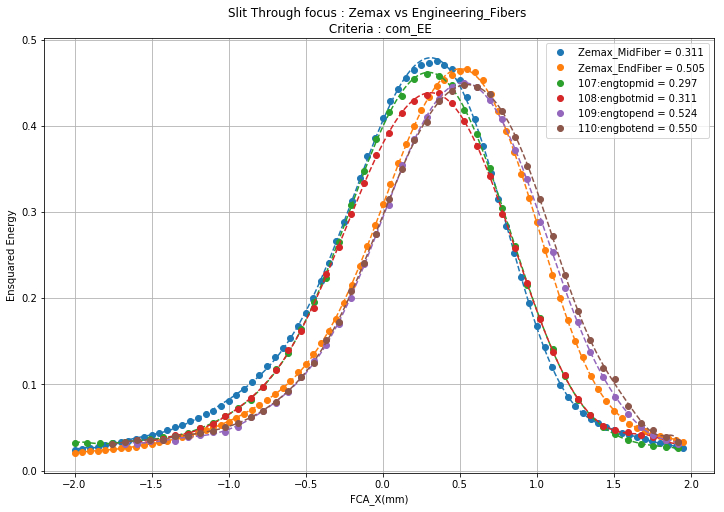

In [22]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)

ax1.plot(zemaxData.Slitdefocus, zemaxData.MidFiber, 'o', label='Zemax_MidFiber = %.3f' % zemaxMidFit.focus)
ax1.plot(zemaxMidFit.x, zemaxMidFit.y, '--', color=ax1.get_lines()[-1].get_color())
if vline:
    ax1.vlines(color=ax1.get_lines()[-1].get_color(), **zemaxMidFit.vline)

ax1.plot(zemaxData.Slitdefocus, zemaxData.ExtremeFiber, 'o', label='Zemax_EndFiber = %.3f' % zemaxEndFit.focus)
ax1.plot(zemaxEndFit.x, zemaxEndFit.y, '--', color=ax1.get_lines()[-1].get_color())
if vline:
    ax1.vlines(color=ax1.get_lines()[-1].get_color(), **zemaxEndFit.vline)

for experimentId, raw_df in cube.groupby('experimentId'):
    df = raw_df[lneg:lpos]
    fit_EE = fitparabola(x=df['fca_x'], y=df[crit], deg=15, focus='max')

    ax1.plot(df['fca_x'], df[crit], 'o', label='%i:%s = %.3f' % (experimentId, descriptions.fiber[experimentId], fit_EE.focus))
    ax1.plot(fit_EE.x, fit_EE.y, '--', color=ax1.get_lines()[-1].get_color())
    if vline:
        ax1.vlines(color=ax1.get_lines()[-1].get_color(), **fit_EE.vline)

lns = [line for i, line in enumerate(ax1.get_lines()) if not i % 2]
labs = [line.get_label() for line in lns]

ax1.legend(lns, labs)
ax1.set_xlabel('FCA_X(mm)')
ax1.set_ylabel('Ensquared Energy')

plt.title('Slit Through focus : Zemax vs Engineering_Fibers \n Criteria : %s' %crit)
plt.grid()